In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import manifold
from matplotlib import pyplot as plt

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
plt.rcParams['font.family'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

In [2]:
%store -r samples_data
%store -r threshold
%store -r cluster_3rd
cluster = cluster_3rd

In [3]:
# 对于每个类别进行判别
samples_features = cluster.iloc[:, 2:]
datetime_features = cluster[("时间", 'Unnamed: 1_level_1')]  # 时间性质
source_features = samples_features[samples_features.columns[[x for x in range(0, 7)]]]  # 原料性质
produc_features = samples_features[samples_features.columns[[x for x in range(7, 10)]]]  # 产品性质
manule_features = samples_features[samples_features.columns[[x for x in range(14, samples_features.shape[1])]]]  # 操作属性

<AxesSubplot:xlabel='None-None', ylabel='None-None'>

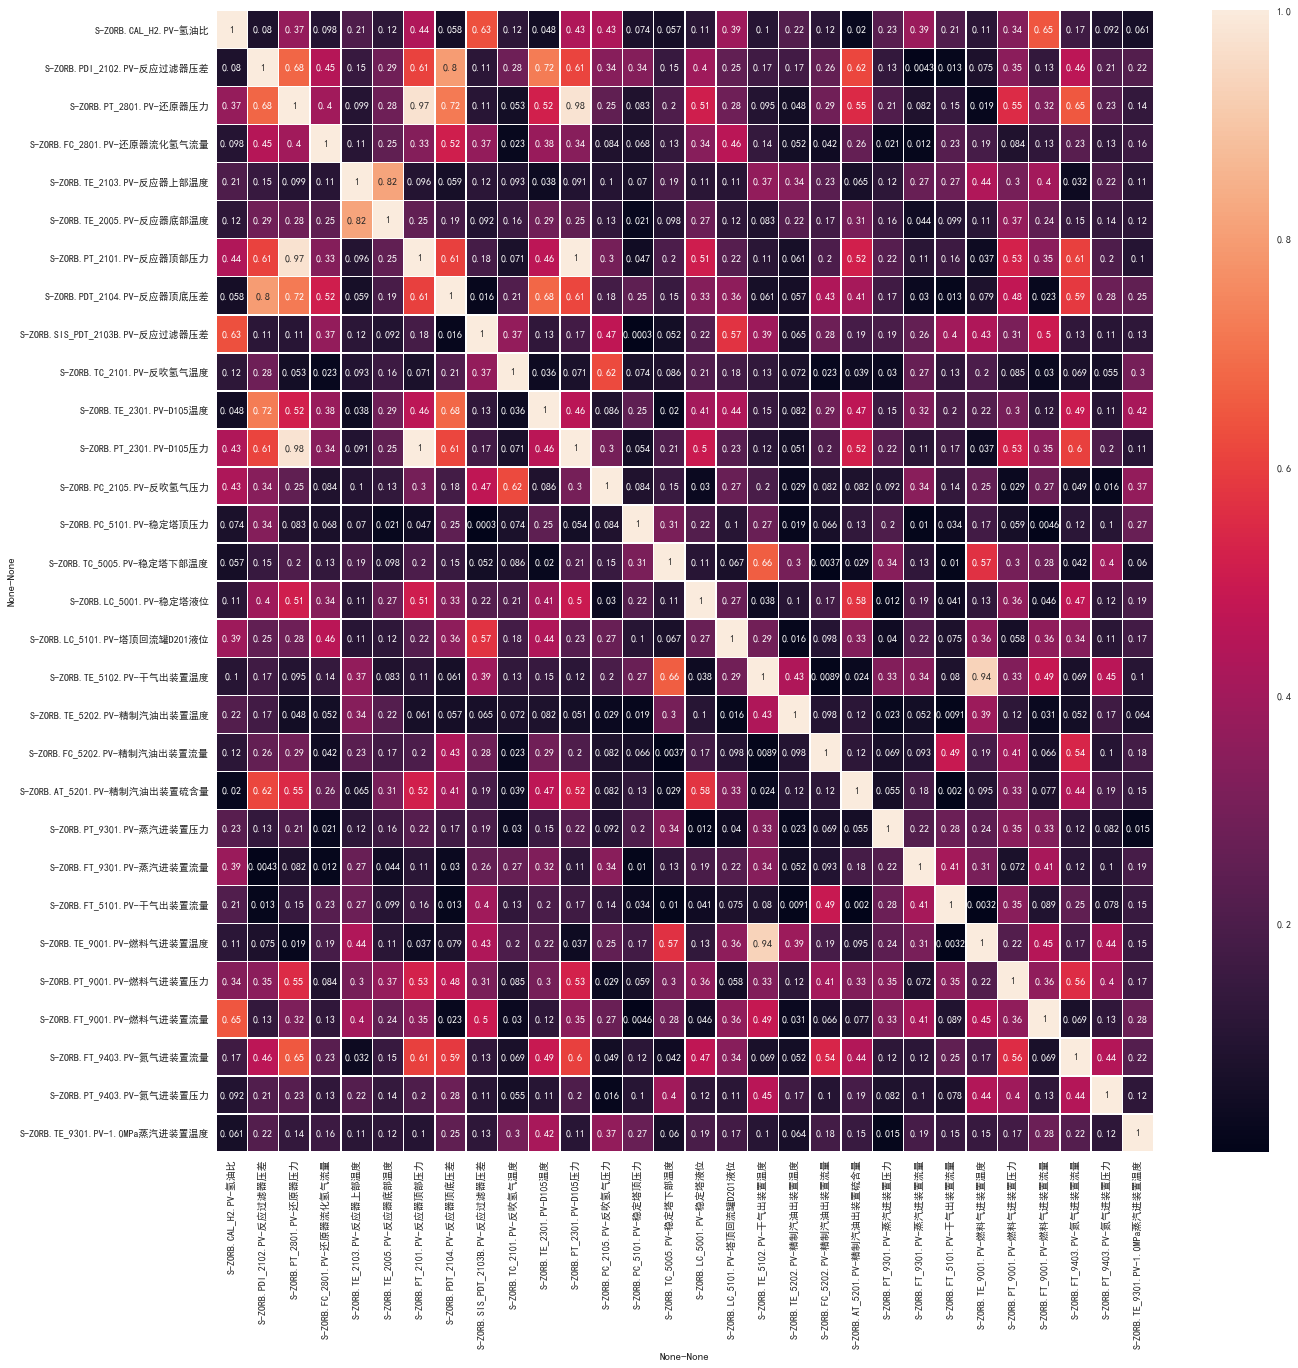

In [4]:
# 计算 操作属性 间的 相关系数 矩阵进行降维
manule_features_corr = manule_features.corr(method='spearman').abs()
# 展示 属性间 相关关系 热力图
fig, ax = plt.subplots(figsize=(21, 21))
sns.heatmap(manule_features_corr.iloc[:30, :30], annot=True, linewidths=.5, ax=ax)  # 只取出前 30 个属性作为一个例子

In [5]:
# Upper triangle of correlations
upper = manule_features_corr.where(np.triu(np.ones(manule_features_corr.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 316 columns to remove.


In [6]:
manule_features = manule_features.drop(columns = to_drop)
manule_features.head()

,S-ZORB.CAL_H2.PV,S-ZORB.PDI_2102.PV,S-ZORB.TE_2103.PV,S-ZORB.TC_2101.PV,S-ZORB.PC_5101.PV,S-ZORB.TC_5005.PV,S-ZORB.PT_9301.PV,S-ZORB.FT_9301.PV,S-ZORB.PT_9402.PV,S-ZORB.LC_1201.PV,S-ZORB.LC_1202.PV,S-ZORB.PC_2601.PV,S-ZORB.PDI_2703A.PV,S-ZORB.LI_9102.DACA,S-ZORB.LC_3301.DACA,S-ZORB.PC_3301.DACA,S-ZORB.LT_2901.DACA,S-ZORB.LT_1002.DACA,cluster
,氢油比,反应过滤器压差,反应器上部温度,反吹氢气温度,稳定塔顶压力,稳定塔下部温度,蒸汽进装置压力,蒸汽进装置流量,非净化风进装置压力,D104液面,D121液面,再生器压力,D110顶底压差,D-204液位,D123冷凝水罐液位,D-123压力,D-109吸附剂料位,D-101脱水包液位,
291,0.287452,18.167657,418.126585,245.595297,0.650025,115.468943,0.520918,1475.044850,0.675932,50.038723,50.000458,0.109983,41.861253,54.121831,50.370906,0.280075,18.979700,-4.966251,3
290,0.281411,19.731644,426.073785,244.869150,0.650028,126.513545,0.883286,2000.382400,0.668197,49.984607,50.012352,0.110103,43.616547,43.995125,50.122805,0.279996,35.464191,-4.750701,3
289,0.271662,21.222581,422.599438,244.989058,0.650032,124.712655,0.719127,1793.901000,0.644786,50.031432,50.032995,0.109996,40.600229,60.397504,50.062898,0.280724,38.592956,-4.197774,3
191,0.249024,21.933501,426.624118,239.806112,0.659977,120.955955,0.710789,1096.928295,0.575532,49.989932,49.997730,0.110022,39.172991,26.294878,49.280835,0.351585,-0.005617,-4.967929,3
190,0.257949,22.468304,425.299582,246.003505,0.659998,116.296182,0.937952,528.955810,0.649209,50.010287,50.013929,0.109953,45.060587,73.269254,49.840785,0.349454,-0.004616,-4.970848,3


In [7]:
print(source_features.reindex().shape)
print(produc_features.reindex().shape)
print(manule_features.reindex().shape)

(71, 7)
(71, 3)
(71, 19)


In [8]:
y = produc_features[('产品性质', 'RON损失\n（不是变量）')].to_numpy()
X = manule_features.to_numpy()

In [9]:
# Bootstrap Sampling
def bootstrap(data, size):
    return [random.choice(data) for _ in range(size)]

In [10]:
# 使用 T-SNE 进行数据降维
# X是特征，不包含target; X_tsne 是已经降维之后的特征
# 指定降维后的维数
relate_features = set()
max_iter = 60
num_iter = 0
features_pool = list(set(manule_features.keys().to_numpy()))

while len(relate_features) <= int(len(features_pool)/3) and num_iter <= max_iter:
    choice_features = bootstrap(features_pool, int(manule_features.shape[1]/2))
    re_dimension = int(len(list(set(choice_features)))/3)
    tsne = manifold.TSNE(n_components=re_dimension, perplexity=6, n_iter=6000, init='pca', method="exact")
    X_tsne = tsne.fit_transform(manule_features[list(set(choice_features))].to_numpy())
    print(f"num_iter => {num_iter} 原始样本数据维度 {len(list(set(choice_features)))}. t-SNE降维后的数据维度 {X_tsne.shape[-1]}")
    tSNE_features = pd.DataFrame(data=X_tsne, columns=[f'feature_{x + 1}' for x in range(re_dimension)])
    tSNE_features_full = tSNE_features.join(samples_data[[('产品性质', 'RON损失\n（不是变量）')]])
    tSNE_features_full_corr = tSNE_features_full.corr(method='spearman').abs().replace(1.0, np.nan)
    tSNE_feature = tSNE_features_full_corr[('产品性质', 'RON损失\n（不是变量）')].idxmax()
    combine_features = manule_features[features_pool].join(pd.DataFrame(data=tSNE_features[[tSNE_feature]].values, columns=[('t-SNE', 'max-relative')]))
    combine_features_corr = combine_features.corr(method='spearman').abs().replace(1.0, np.nan)
    choice_feature = combine_features_corr[('t-SNE', 'max-relative')].idxmax()
    relate_features.add(choice_feature)
    num_iter += 1

print(relate_features)

num_iter => 0 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 1 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 2 原始样本数据维度 7. t-SNE降维后的数据维度 2
num_iter => 3 原始样本数据维度 7. t-SNE降维后的数据维度 2
num_iter => 4 原始样本数据维度 7. t-SNE降维后的数据维度 2
num_iter => 5 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 6 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 7 原始样本数据维度 7. t-SNE降维后的数据维度 2
num_iter => 8 原始样本数据维度 8. t-SNE降维后的数据维度 2
num_iter => 9 原始样本数据维度 9. t-SNE降维后的数据维度 3
num_iter => 10 原始样本数据维度 7. t-SNE降维后的数据维度 2
{('S-ZORB.LC_1202.PV', 'D121液面'), ('S-ZORB.TE_2103.PV', '反应器上部温度'), ('S-ZORB.TC_5005.PV', '稳定塔下部温度'), ('S-ZORB.LT_2901.DACA', 'D-109吸附剂料位'), ('S-ZORB.TC_2101.PV', '反吹氢气温度'), ('S-ZORB.PT_9301.PV', '蒸汽进装置压力'), ('S-ZORB.PT_9402.PV', '非净化风进装置压力')}


In [11]:
# 增加题目要求的变量作为建模属性
model_features = manule_features[list(relate_features)].join(source_features[('原料性质', '辛烷值RON')])
model_features = model_features.join(datetime_features)
model_features.describe()

,S-ZORB.LC_1202.PV,S-ZORB.TE_2103.PV,S-ZORB.TC_5005.PV,S-ZORB.LT_2901.DACA,S-ZORB.TC_2101.PV,S-ZORB.PT_9301.PV,S-ZORB.PT_9402.PV,原料性质,时间
,D121液面,反应器上部温度,稳定塔下部温度,D-109吸附剂料位,反吹氢气温度,蒸汽进装置压力,非净化风进装置压力,辛烷值RON,Unnamed: 1_level_1
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,7.100000e+01
mean,50.002774,424.110955,125.220015,18.165585,238.276233,0.842328,0.614015,-1.182747,1.560017e+18
std,0.024639,2.330280,3.511514,14.326526,9.172379,0.085241,0.017252,0.857188,2.312042e+16
min,49.950263,418.126585,115.468943,-0.016795,180.756203,0.520918,0.575532,-3.207485,1.498810e+18
25%,49.991201,422.783878,124.455544,4.247746,238.960614,0.809246,0.606249,-1.675747,1.547323e+18
50%,50.001052,423.876070,126.456598,18.979700,239.982875,0.841558,0.611378,-1.165168,1.568362e+18
75%,50.013790,425.500301,127.317692,33.335889,240.117480,0.874791,0.622098,-0.711320,1.579723e+18
max,50.065997,431.195185,130.563312,41.447218,246.003505,1.279560,0.675932,0.990611,1.587456e+18


In [12]:
weight_3rd = manule_features.shape[0]/samples_features.shape[0]
model_features_3rd = model_features
produc_features_3rd = produc_features
%store model_features_3rd
%store produc_features_3rd
%store weight_3rd

Stored 'model_features_3rd' (DataFrame)
Stored 'produc_features_3rd' (DataFrame)
Stored 'weight_3rd' (float)
